In [191]:
# Install the packages if necessary
#install.packages("devtools")
#install.packages("bgsmtr")
#install.packages("corrplot")
#install.packages("pheatmap")
#install.packages('coefplot')
#library(devtools)
#install.packages('glinternet')
require(glinternet)
library(glmnet)
library(corrplot)
#library(pheatmap)
library(tidyverse)
library(coefplot)
library(cowplot)
#install_github("monogenea/gflasso")
#install.packages('glmnet')

IDs 3, 4, 69 and 87 do not have any data from visit 3. These participants were excluded from analyses at visit 3 because they did not complete the fully controlled diet intervention period. 

In the PlosOne paper (where only group 1 and 3 were analyzed), 2 additional participants that were found to be outliers were excluded. Stine and I were wondering if, based on your analyses, you find any participants that are outliers and therefore should be excluded? 

In [341]:
dat = read.table('./dataset/data_total.csv',dec=',',sep=';',header=T)

In [342]:
table(dat$visit)


 2  3  4 
54 54 54 

In [343]:
#subset data to include visit2 and 3 only
dat %>% filter(visit!=4) -> dat_sub
#remove IDs 3, 4, 69 and 87 for non-compliant reason
dat_sub %>% filter(!(id %in% c(3, 4, 58, 69, 87))) -> dat_sub
dat_sub$visit <- dat_sub$visit %>% type.convert()
dat_sub$group <- dat_sub$group %>% type.convert()
dat_sub$sex <- dat_sub$sex %>% type.convert()

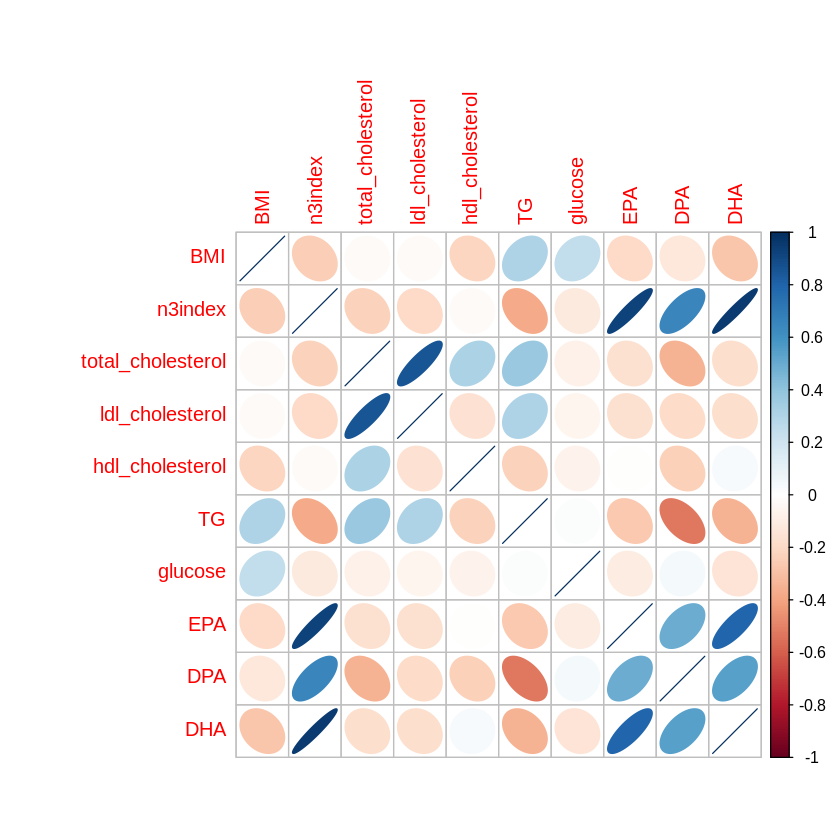

In [344]:
z = as.matrix(dat_sub[,7:16])
corrplot(cor(z,use='pairwise.complete.obs'),method='ellipse')

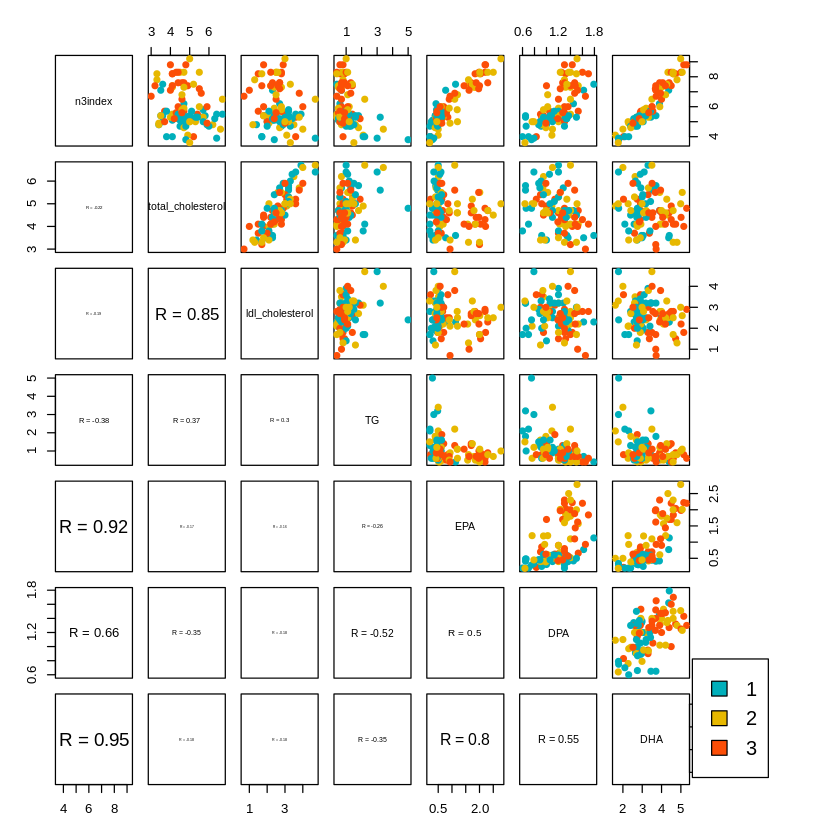

In [345]:
# visual inspection of the observation by group
my_cols <- c("#00AFBB", "#E7B800", "#FC4E07")
panel.cor <- function(x, y){
    usr <- par("usr"); on.exit(par(usr))
    par(usr = c(0, 1, 0, 1))
    r <- round(cor(x, y), digits=2)
    txt <- paste0("R = ", r)
    cex.cor <- 1.5
    text(0.5, 0.5, txt, cex = abs(cex.cor * r))
}
# Customize upper panel
upper.panel<-function(x, y){
  points(x,y, pch = 19, col = my_cols[as.factor(dat_sub$group)])
}
# Create the plots
pairs(~n3index + total_cholesterol + ldl_cholesterol + TG + EPA + DPA + DHA, 
        dat_sub ,lower.panel = panel.cor,
        upper.panel = upper.panel, oma=c(3,3,3,9))
par(xpd=TRUE)
legend("bottomright", legend = as.vector(unique(dat_sub$group)),  
    fill=my_cols)


In [385]:
# Run lasso with each clinical parameter as y

# Create subset for each visit on the new dataset
dat.visit2 = subset(dat_sub, subset=(visit==2))
dat.visit3 = subset(dat_sub, subset=(visit==3))

# Group two fish oil groups into one, constrasting the control
dat.visit3$trt <- dat.visit3$group
#dat.visit3$trt[dat.visit3$group>1] = 1
#dat.visit3$trt[dat.visit3$group==1] = 0
dat.visit3$trt = as.factor(dat.visit3$trt)
dat.visit3$sex = as.factor(dat.visit3$sex)
dat.visit2$trt <- dat.visit3$trt

dat.diff = subset(dat.visit3,select=-c(id,visit,group,compliance,sex,age,trt)) -
            subset(dat.visit2,select=-c(id,visit,group,compliance,sex,age,trt))
dat.diff = cbind(subset(dat.visit3,
           select=c(id,visit,trt,compliance,sex,age)), dat.diff)

In [414]:
Y = subset(dat.diff, select = c(n3index,total_cholesterol,ldl_cholesterol,TG,EPA,DPA,DHA))
X = subset(dat.diff, select = -c(id,visit,compliance,n3index,total_cholesterol,ldl_cholesterol,TG,EPA,DPA,DHA))
## Contrust variables required for glithernet package
numLevels <- X %>% sapply(nlevels)
numLevels[numLevels==0] <- 1
i_num <- sapply(X, is.numeric)
idx_num <- (1:length(i_num))[i_num]
idx_cat <- (1:length(i_num))[!i_num]
X$trt <- as.integer(X$trt)-1
X$sex <- as.integer(X$sex)-1

There is a group analogue to the lasso, called the group-lasso [Yuan and Lin, 2006], that sets groups of variables to zero. The idea behind this method is to set up main effects and interactions via groups of variables, and then perform parameter selection via the group-lasso.
 glinternet (group-lasso interaction network), a method for learning first-order interactions that can be applied to categorical variables with arbitrary numbers of levels, continuous variables, and combinations of the two. It can handle up to 360M candidate interactions without pre-screening of candidates for main effect and interactions.
 
overlap group-lasso is a variant of the group-lasso where the groups of variables are allowed to have overlaps, i.e. some variables can show up in more than one group. However, each time a variable shows up in a group, it gets a new coefficient.

In [415]:
get_lasso_interaction<- function(X, Y, numLevels, response_var='n3index',i_num = i_num){
    # locate index of the respon
    i = which(names(Y)== response_var)
    #Set aside training data for cv
    n = dim(Y)[1]
    set.seed(1234)
    cv_fit <- glinternet.cv(X, unlist(Y[i]), numLevels, 
                        interactionCandidates=c(1),numCores=2)
    i_1Std <- which(cv_fit$lambdaHat1Std == cv_fit$lambda)
    coefs <- coef(cv_fit$glinternetFit)[[i_1Std]]
    idx_num <- (1:length(i_num))[i_num]
    idx_cat <- (1:length(i_num))[!i_num]
    plot(cv_fit)
    cat('Main Effects: \n')
    cat('Cat. var.:  \n', names(numLevels)[idx_cat[coefs$mainEffects$cat]],'\n')
    cat('Cont. var.: \n', paste(names(numLevels)[idx_num[coefs$mainEffects$cont]],sep = ','),'\n')
    cat('Interactions: \n')
    cat('Treament:Cont \n', paste(names(numLevels)[idx_num[coefs$interactions$catcont[,2]]],
                                  sep = ','),'\n')
    cat(paste('RMSE = ',sqrt(cv_fit$cvErr[[i_1Std]]),'\n'))
    return(cv_fit)
    }

In [430]:
get_lasso <- function(X, Y, response_var='n3index'){
    # locate index of the respon
    i = which(names(Y)== response_var)
    #Set aside training data for cv
    n = dim(Y)[1]
    set.seed(1234)
#    train = sample(1:n, 2*n/3) #take 2/3 of the data as training
#    cat(paste(round(length(train)/n*100,2),'percent of observation is used as training data \n'))
#    max(table(train)) # if 1, then no ties in the sampled observations
#   test = (1:n)[-train]
    lasso.cv = cv.glmnet(as.matrix(X), as.matrix(Y[i]),nfolds = 10)
    i_1Std <- which(lasso.cv$lambdaHat1Std == lasso.cv$lambda)
    #check cv fit to get lambda.min and lambda.lse
    loglambda_test = c(-10,10)
    cat(paste('lambda.min =', lasso.cv$lambda.min), 'loglambda.min =', log(lasso.cv$lambda.min), '\n')
    cat(paste('lambda se =', lasso.cv$lambda.1se),'\n')
    plot(lasso.cv)
    #extract non-zero coef.
    cat('Main Effects: \n')    
    
    cat('RMSE = ',sqrt(min(lasso.cv$cvm)),'\n')    
return(lasso.cv)
}

In [307]:
#    lasso.fit = glmnet(as.matrix(X[train,]), as.matrix(Y[train,i]))
#    lasso.fita = assess.glmnet(lasso.fit, newx=as.matrix(X[test,]), newy=as.matrix(Y[test,i]))
#    plot(lasso.fit$lambda, log="x",lasso.fita$mae,xlab="Log Lambda",ylab="Mean Absolute Error")

Main Effects: 
Cat. var.:  
 trt 
Cont. var.: 
 PC.40.2._73 PE.40.0e._112 PG.36.1._124 SM.d18.0.24.0._155 TG.50.4._214 TG.54.3._233 unknown_264 unknown_299 unknown_303 unknown_312 unknown_328 unknown_367 unknown_369 unknown_375 unknown_379 unknown_409 unknown_442 unknown_446 unknown_541 LysoPC.20.5._13 unknown_342 
Interactions: 
Treament:Cont 
 LysoPC.20.5._13 unknown_342 unknown_446 
RMSE =  0.660485173579217 


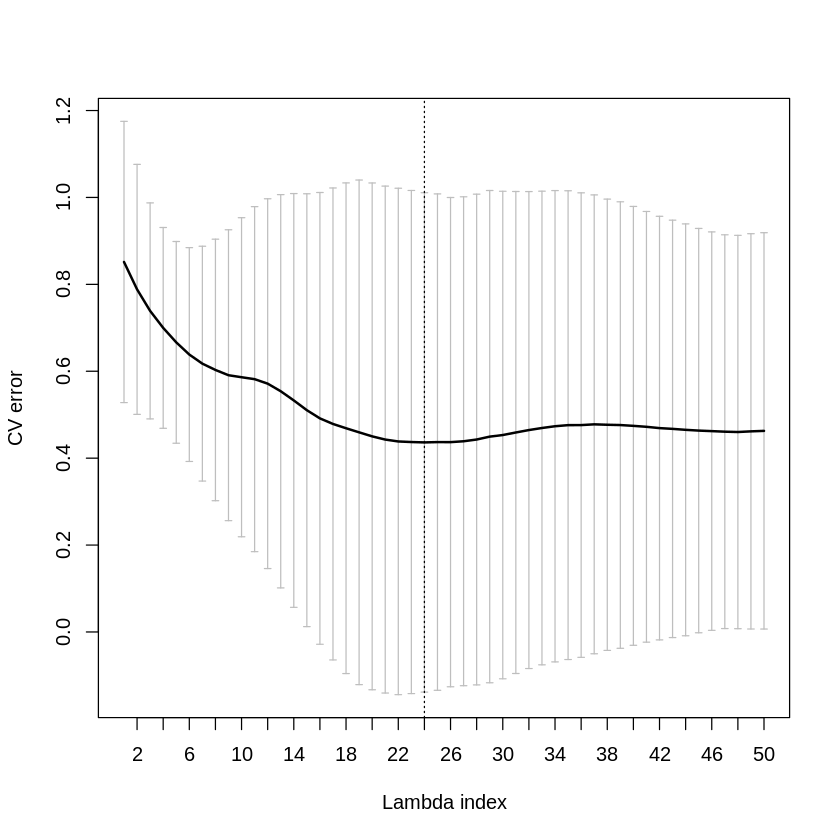

In [416]:
zz <- get_lasso_interaction(X,Y,numLevels,'n3index',i_num)


lambda.min = 0.0432143720085421 loglambda.min = -3.141582 
lambda se = 0.403018678848164 
Main Effects: 
RMSE =  0.8957234 


,Value,SE,Coefficient
,<dbl>,<dbl>,<chr>
(Intercept),0.329835201,NA,(Intercept)
trt,0.354141420,NA,trt
sex,0.006653806,NA,sex
PC.34.4e._44,0.047590263,NA,PC.34.4e._44
PC.38.5._65,0.002173011,NA,PC.38.5._65
PC.38.5e._66,-0.042975407,NA,PC.38.5e._66
PC.40.2._73,2.241821806,NA,PC.40.2._73
PE.38.4._100,-0.002411064,NA,PE.38.4._100
PE.40.0e._112,0.053475201,NA,PE.40.0e._112


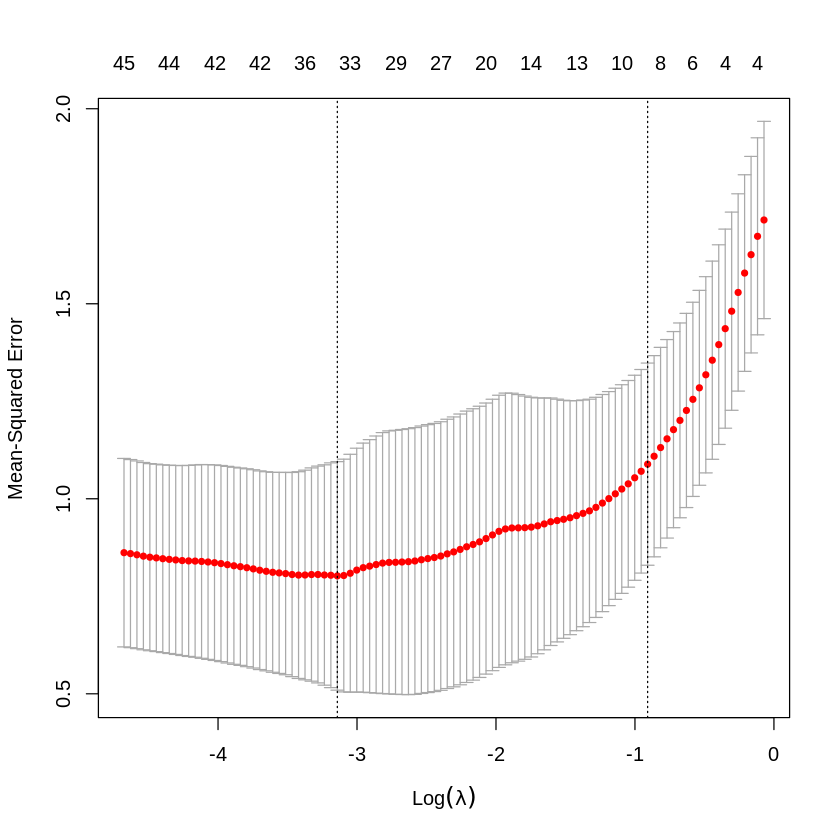

In [431]:
zx <- get_lasso(X,Y,'n3index')
extract.coef(zx)

In [429]:
zx


Call:  cv.glmnet(x = as.matrix(X), y = as.matrix(Y[i]), nfolds = 10) 

Measure: Mean-Squared Error 

    Lambda Measure     SE Nonzero
min 0.0432  0.8023 0.2930      34
1se 0.4030  1.0888 0.2592       8

Loading required package: reshape2


Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths


No id variables; using all as measure variables



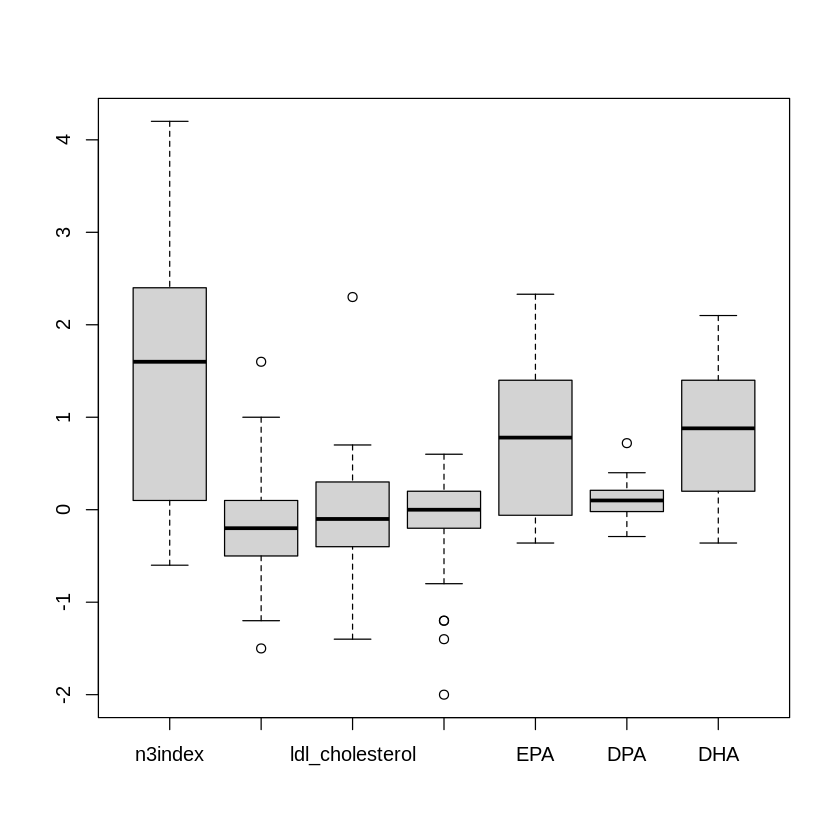

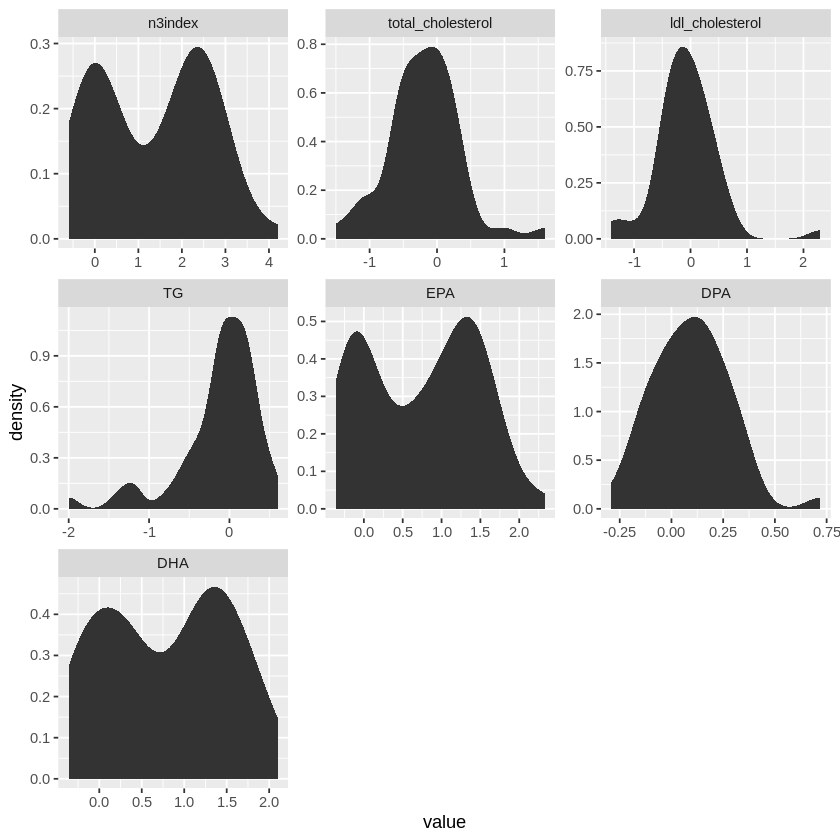

In [15]:
require(reshape2)
boxplot(Y)
melt.diff <- melt(Y)
ggplot(data = melt.diff, aes(x = value)) + 
  stat_density() +
facet_wrap(~variable, scales = "free") + theme_set(theme_cowplot())

Installing package into '/data/xiaoral/lib/R/x86_64-redhat-linux-gnu-library/3.6'
(as 'lib' is unspecified)



In [370]:
    cv_fit <- glinternet.cv(X, unlist(Y['n3index']), numLevels)

In [337]:
    i_1Std <- which(cv_fit$lambdaHat1Std == cv_fit$lambda)
    coefs <- coef(cv_fit$glinternetFit)[[i_1Std]]
    i_num <- sapply(X, is.numeric)
    idx_num <- (1:length(i_num))[i_num]
    idx_cat <- (1:length(i_num))[!i_num]

In [338]:
coefs

$mainEffects
$mainEffects$cat
NULL

$mainEffects$cont
[1] 465 564


$mainEffectsCoef
$mainEffectsCoef$cat
list()

$mainEffectsCoef$cont
$mainEffectsCoef$cont[[1]]
[1] 0.3799151

$mainEffectsCoef$cont[[2]]
[1] -0.06712205



$interactions
$interactions$catcat
NULL

$interactions$contcont
NULL

$interactions$catcont
NULL


$interactionsCoef
$interactionsCoef$catcat
list()

$interactionsCoef$contcont
list()

$interactionsCoef$catcont
list()

In [384]:
    i_1Std <- 21
    coefs <- coef(cv_fit$glinternetFit)[[i_1Std]]
    i_num <- sapply(X, is.numeric)
    idx_num <- (1:length(i_num))[i_num]
    idx_cat <- (1:length(i_num))[!i_num]

names(numLevels)[idx_num[coefs$interactions$catcont[,2]]]

character(0)

[1] 0.02030191

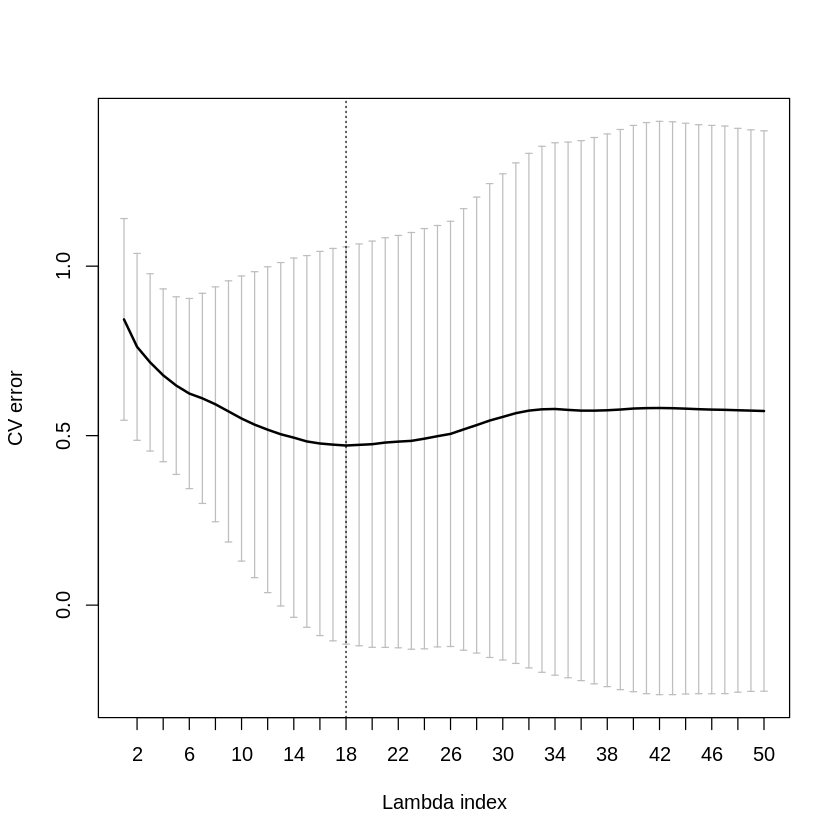

In [378]:
plot(cv_fit)
cv_fit$lambda[21]